# Parameter Sensitivity Studies for ACC 2023 Paper Submission

9/21/2023

Andrew Weng

In [2]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%load_ext autoreload

plotter.initialize(plt, style='ieee')

In [3]:
# Initialize some constants

F = 96485.33212    # C/mol      Faraday's constant
T = 273.15 + 25    # Kelvin     Temperature
R = 8.314          # J/mol/K    Universal gas constant

# Run the simulation

In [4]:
%autoreload 

Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/single_sei.yaml')
tag = cell.get_tag()

# sim = cellsim.Simulation(cell, 520*3600)
sim = cellsim.Simulation(cell, 70*3600)

# Formation
sim.run_rest(1, rest_time_hrs=0.5)
sim.run_chg_cccv(2, 2.5/10, Icv, vmax)
sim.run_dch_cccv(2, Idch, Idch, vmin)
sim.run_chg_cccv(3, 2.5/10, Icv, vmax)
sim.run_dch_cccv(3, Idch, Idch, vmin)
sim.run_chg_cccv(4, 2.5/10, Icv, vmax)
sim.run_dch_cccv(4, Idch, Idch, vmin)


Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


/Users/aweng/code/formation-modeling/src/cellsim.py:559: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/fig_timeseries_1.tif',
/Users/aweng/code/formation-modeling/src/cellsim.py:677: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/fig_timeseries_2.tif', bbox_inches='tight',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


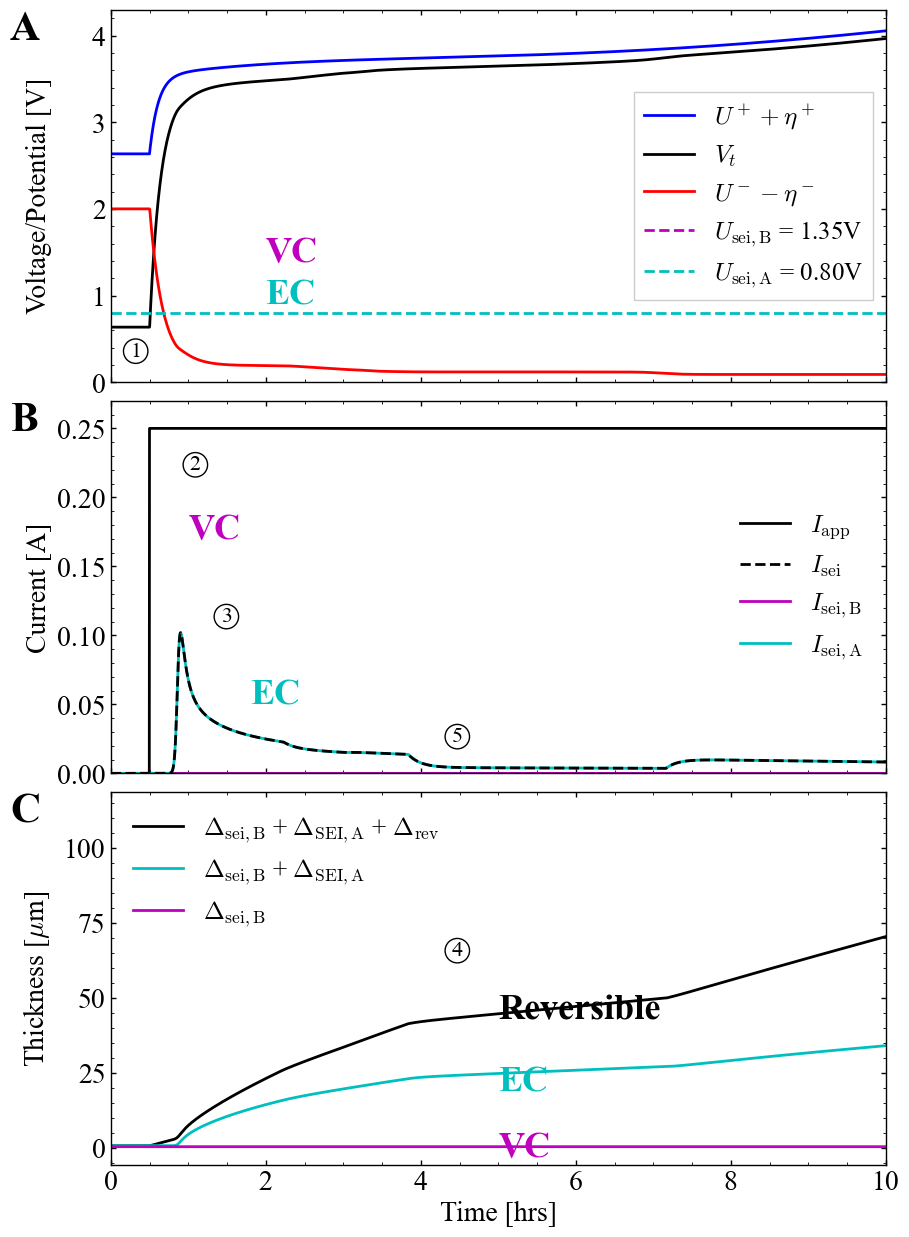

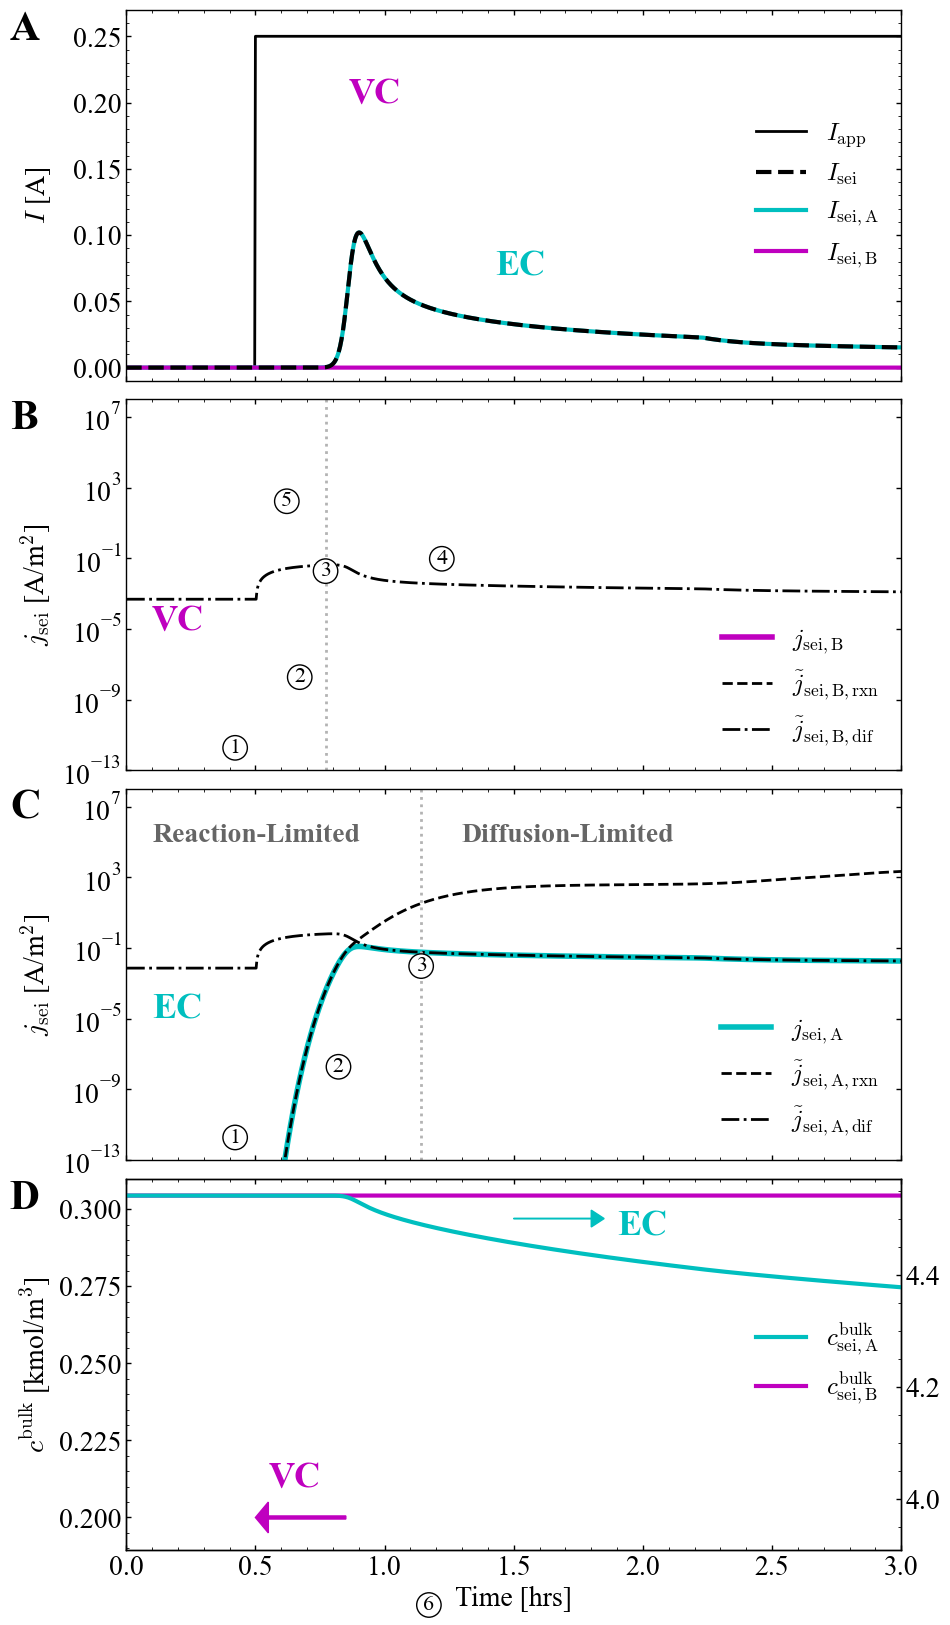

In [5]:
%autoreload
sim.plot_view_1(xlims=(0, 10), to_save=True)
sim.plot_view_2(xlims=(0.0, 3.0), to_save=True)

In [113]:
def run_sims_with_config(U_SEI1, D_SEI11, k_SEI1,
                           gamma, rest_time_hrs,
                           c_rate, c_cv, vmin, vmax):
    """
    Run a simulation with a custom configuration. 

    User specifies the parameters to vary.

    The function calculates and returns a bunch of things in a tuple:
    - sim: the simulation output
    - FCE
    - SEI thickness
    - JSEI evaluated at some operating point
    - Formation time in hours
    """


    # Set the parameters
    cell = cellsim.Cell()
    cell.load_config('params/single_sei.yaml')
    cell.U_SEI1         = U_SEI1
    cell.D_SEI11        = D_SEI11
    cell.k_SEI1         = k_SEI1
    cell.gamma_boost    = gamma


    # Run the simulation
    sim = cellsim.Simulation(cell, 160*3600)
    sim.run_rest(1, rest_time_hrs=rest_time_hrs)
    sim.run_chg_cccv(2, 2.5*c_rate, 2.5*c_cv, vmax)
    sim.run_dch_cccv(2, -2.5*c_rate, -2.5*c_rate, vmin)
    sim.run_chg_cccv(3, 2.5*c_rate, 2.5*c_cv, vmax)
    sim.run_dch_cccv(3, -2.5*c_rate, -2.5*c_rate, vmin)
    sim.run_chg_cccv(4, 2.5*c_rate, 2.5*c_cv, vmax)
    sim.run_dch_cccv(4, -2.5*c_rate, -2.5*c_rate, vmin)

    # Process the results
    df_sim = sim.get_results()
    df_agg = df_sim.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')

    # Calculate CE
    ce_sim = []
    cycle_index = np.array([2, 3, 4])
    for i in cycle_index:
        if 1 in df_agg[i].index: # has CV mode
            ce_sim.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))
        else:
            ce_sim.append(df_agg[i][2] / (df_agg[i][0]))
        
    ce_sim = np.array(ce_sim)

    # Get the total SEI thickness
    sei_thickness = df_sim['delta_sei'].iloc[-1]

    # Calculate jsei at a fixed point
    theta_n = 0.8
    jrxn = cell.n_SEI1 * F * cell.k_SEI1 * cell.c_SEI1_0 * \
        np.exp(- cell.alpha_SEI * cell.n_SEI1 * F / (R * T) * (cell.Un(theta_n) - cell.U_SEI1))
    jdif = cell.D_SEI11 * cell.c_SEI1_0 * cell.n_SEI1 * F / sei_thickness
    jsei = (1 / (1/jrxn + 1/jdif))

    form_time_hrs = df_sim['t'].iloc[-1]/3600 - 0.5 # Take 30mins away for rest time

    return (sim, ce_sim[0], sei_thickness, jsei, form_time_hrs)


In [114]:
U_SEI1 = 1.35
D_SEI11 = 4.4e-20
k_SEI1 = 3.0e-17
gamma = 3.4e7
rest_time_hrs = 0.5
c_rate = 1/10
c_cv = 1/10
vmin = 3.0
vmax = 4.2

out = run_sims_with_config(U_SEI1, D_SEI11, k_SEI1, gamma, rest_time_hrs, c_rate, c_cv, vmin, vmax)


Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


In [163]:
num_sims = 31
half = int(num_sims/2)

u_sei_vec = np.linspace(0.5, 3.1, num_sims)
d_sei_vec = np.logspace(-22, -20, num_sims)

k_sei_vec = np.logspace(-19, -15, num_sims)
gamma_vec = np.logspace(6, 7, num_sims)
c_rate_vec = np.linspace(1/20, 1/5, num_sims)

In [176]:
u_sei_vec[half]

1.8

In [184]:
d_sei_vec[half]

1e-21

In [185]:
k_sei_vec[half]

1e-17

In [187]:
gamma_vec[half]

3162277.6601683795

In [186]:
c_rate_vec[half]

0.125

In [164]:
out_vec = []
for u_sei in u_sei_vec:
    out = run_sims_with_config(u_sei, d_sei_vec[half], k_sei_vec[half], gamma_vec[half], 
                               rest_time_hrs, c_rate_vec[half], c_cv, vmin, vmax)
    out_vec.append(out)
df_out_u_sei = pd.DataFrame(out_vec, columns=['sim', 'fce', 'delta_sei', 'jsei', 'time_hrs'])

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


In [165]:
out_vec = []
for d_sei in d_sei_vec:
    out = run_sims_with_config(u_sei_vec[half], d_sei, k_sei_vec[half], 
                               gamma_vec[half], rest_time_hrs, c_rate_vec[half], c_cv, vmin, vmax)
    out_vec.append(out)
df_out_d_sei = pd.DataFrame(out_vec, columns=['sim', 'fce', 'delta_sei', 'jsei', 'time_hrs'])

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


In [166]:
out_vec = []
for k_sei in k_sei_vec:
    out = run_sims_with_config(u_sei_vec[half], d_sei_vec[half], k_sei, 
                               gamma_vec[half], rest_time_hrs, c_rate_vec[half], c_cv, vmin, vmax)
    out_vec.append(out)
df_out_k_sei = pd.DataFrame(out_vec, columns=['sim', 'fce', 'delta_sei', 'jsei', 'time_hrs'])

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


In [167]:
out_vec = []
for gamma in gamma_vec:
    out = run_sims_with_config(u_sei_vec[half], d_sei_vec[half], k_sei_vec[half],
                               gamma, rest_time_hrs, c_rate_vec[half], c_cv, vmin, vmax)
    out_vec.append(out)
df_out_gamma = pd.DataFrame(out_vec, columns=['sim', 'fce', 'delta_sei', 'jsei', 'time_hrs'])

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


In [168]:
out_vec = []
for c_rate in c_rate_vec:
    if c_cv > c_rate:
        c_cv = c_rate
    out = run_sims_with_config(u_sei_vec[half], d_sei_vec[half], k_sei_vec[half], 
                               gamma_vec[half], rest_time_hrs, c_rate, c_cv, vmin, vmax)
    out_vec.append(out)
df_out_c_rate = pd.DataFrame(out_vec, columns=['sim', 'fce', 'delta_sei', 'jsei', 'time_hrs'])

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...


/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_2999/2707178782.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('outputs/figures/param_sensitivity.png', dpi=200)


<Figure size 700x500 with 0 Axes>

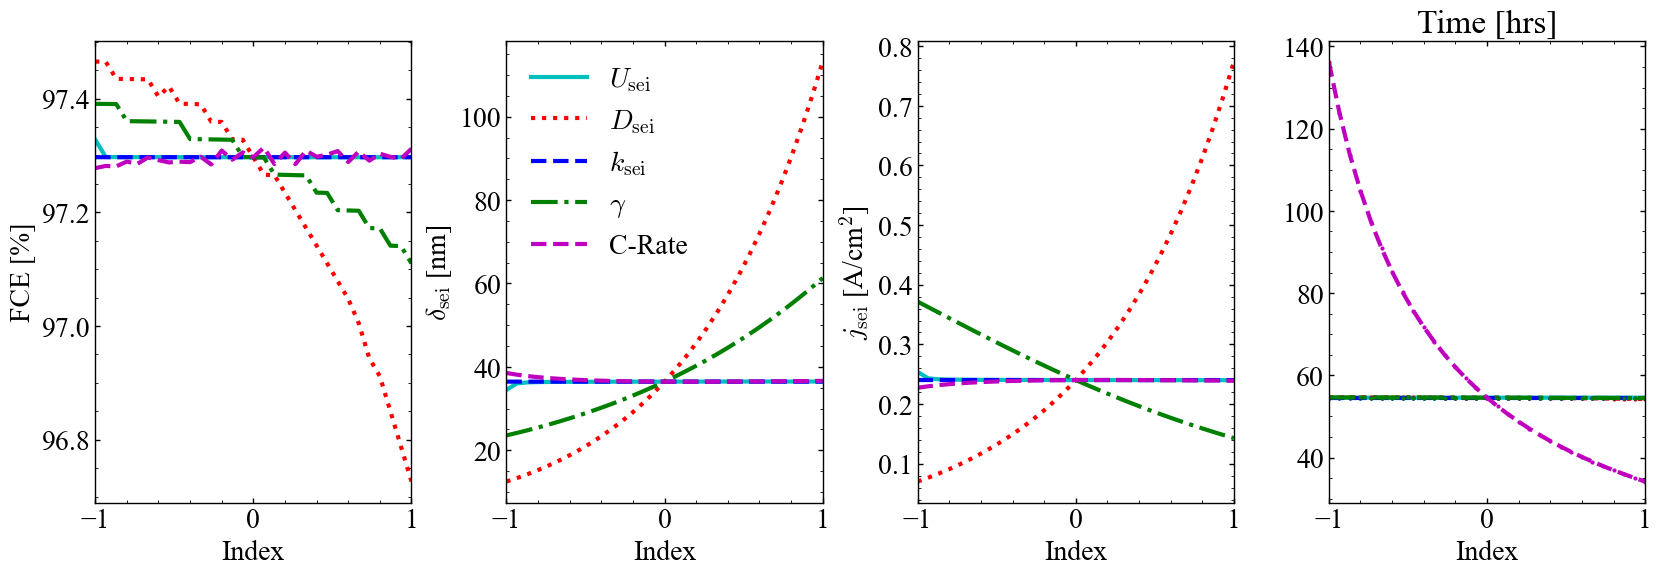

In [213]:

df_out_vec = [df_out_u_sei, df_out_d_sei, df_out_k_sei, df_out_gamma, df_out_c_rate]
label_vec = ['$U_\mathrm{sei}$', '$D_\mathrm{sei}$', '$k_\mathrm{sei}$', '$\gamma$', 'C-Rate']

index = np.arange(-15, 16, 1)

fh = plt.figure(figsize=(7, 5))
num_subplots = 4

gridspec = dict(hspace=0.25, wspace=0.30, width_ratios=np.ones(num_subplots))

fig, axs = plt.subplots(ncols=num_subplots, nrows=1,
                        figsize=(num_subplots * 5, 6),
                        gridspec_kw=gridspec)

col_vec = ['c', 'r', 'b', 'g', 'm']
ls_vec = ['-', ':', '--', '-.', '--']

[ax.grid(False) for ax in axs]

for (df, label, c, ls) in zip(df_out_vec, label_vec, col_vec, ls_vec):

    i = 0
    axs[i].plot(index/np.max(index), df['fce']*100, label=label, c=c, ls=ls, lw=3)
    axs[i].set_ylabel('FCE [%]')

    i += 1
    axs[i].plot(index/np.max(index), df['delta_sei'] * 1e9, label=label, c=c, ls=ls, lw=3)
    axs[i].set_ylabel('$\delta_\mathrm{sei}$ [nm]')

    i += 1
    axs[i].plot(index/np.max(index), df['jsei']*10000, label=label, c=c, ls=ls, lw=3)
    axs[i].set_ylabel('$j_\mathrm{sei}$ [A/cm$^2$]')

    i += 1
    axs[i].plot(index/np.max(index), df['time_hrs'], label=label, c=c, marker='o', ms=2, ls=ls, lw=3)
    axs[i].set_title('Time [hrs]')

axs[1].legend()
[ax.set_xlabel('Index') for ax in axs];
[ax.set_xlim((-1,1)) for ax in axs]
[ax.set_xticks([-1, 0, 1]) for ax in axs]
# [ax.set_yscale('log') for ax in axs];

plt.savefig('outputs/figures/param_sensitivity.png', dpi=200)